In [1]:
import os
import math
import torch
import requests
import numpy as np
from PIL import Image
from tqdm import tqdm  # 导入 tqdm 库
from abc import abstractmethod
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
import torch_optimizer as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

from DDIM_C import GaussianDiffusion
from ldm.modules.diffusionmodules.openaimodel import UNetModel

# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {device_name}")
else:
    print("No GPU available, using CPU.")

GPU Name: NVIDIA GeForce RTX 4090


In [2]:
#Step 1 : 实例化vqmodel
# 加载模型参数
ckpt_path = 'VQf4model.ckpt'
checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)

# 简化版VQModel的类
class VQModel(torch.nn.Module):
    def __init__(self, ddconfig, embed_dim=3,n_embed=8192):
        super().__init__()
        from taming.modules.diffusionmodules.model import Encoder, Decoder
        from taming.modules.vqvae.quantize import VectorQuantizer2 as VectorQuantizer
        # self.encoder = Encoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        self.quantize = VectorQuantizer(n_embed, embed_dim, beta=0.25,
                                        remap=None,
                                        sane_index_shape=False)
        # self.quant_conv = torch.nn.Conv2d(ddconfig["z_channels"], embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1)

    # def encode(self, x):  # 修改方法名称，避免与属性名冲突
    #     h = self.quant_conv(self.encoder(x))
    #     return h

    def decode(self, x, force_not_quantize=False):  # 修改方法名称，避免与属性名冲突
        if not force_not_quantize:
            quant, emb_loss, info = self.quantize(x)
        else:
            quant = x
        dec = self.decoder(self.post_quant_conv(quant))
        return dec

# 初始化简化版模型
vq_model = VQModel(  # 实例化对象的名称改为小写以避免与类名混淆
    ddconfig={
        'double_z': False,
        'z_channels': 3,
        'resolution': 256,
        'in_channels': 3,
        'out_ch': 3,
        'ch': 128,
        'ch_mult': [1, 2, 4],
        'num_res_blocks': 2,
        'attn_resolutions': [],
        'dropout': 0.0
    },
    embed_dim=3,
    n_embed=8192
)

# 加载权重
# 过滤掉与模型不相关的参数
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
elif 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint  # 如果checkpoint文件本身就是状态字典

filtered_state_dict = {k: v for k, v in state_dict.items() if k in vq_model.state_dict()}
vq_model.load_state_dict(filtered_state_dict, strict=False)

vq_model = vq_model.to(device)
for param in vq_model.parameters():
    param.requires_grad = False
# 设置模型为评估模式   
vq_model.eval()

Working with z of shape (1, 3, 64, 64) = 12288 dimensions.


VQModel(
  (decoder): Decoder(
    (conv_in): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (mid): Module(
      (block_1): ResnetBlock(
        (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
        (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (attn_1): AttnBlock(
        (norm): GroupNorm(32, 512, eps=1e-06, affine=True)
        (q): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
        (k): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
        (v): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
        (proj_out): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      )
      (block_2): ResnetBlock(
        (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
        (conv1): Conv2d(512, 512, kernel_

In [3]:
#Step 2 : 实例化GaussianDiffusion
timesteps = 1000
gaussian_diffusion = GaussianDiffusion(timesteps=timesteps,
        beta_schedule='linear',
        linear_start = 0.0015,
        linear_end= 0.0155)

In [4]:
#Step 3 : 实例化Onestep模型和多步模型
unet_config = {
    "image_size": 64,
    "in_channels": 3,
    "out_channels": 3,
    "model_channels": 224,
    "attention_resolutions": [8, 4, 2],
    "num_res_blocks": 2,
    "channel_mult": [1, 2, 3, 4],
    "num_head_channels": 32,
}

onestep = UNetModel(**unet_config)

ckpt_path_u = 'ddim_onestep_finetune.ckpt'
checkpoint_u = torch.load(ckpt_path_u, map_location=device, weights_only=True)

if 'model_state_dict' in checkpoint_u:
    state_dict = checkpoint_u['model_state_dict']
elif 'state_dict' in checkpoint_u:
    state_dict = checkpoint_u['state_dict']
else:
    state_dict = checkpoint_u  # 如果checkpoint文件本身就是状态字典

filtered_state_dict = {k: v for k, v in state_dict.items() if k in onestep.state_dict()}
onestep.load_state_dict(filtered_state_dict, strict=False)

onestep = onestep.to(device)
for param in onestep.parameters():
    param.requires_grad = False
# 设置模型为评估模式   
onestep.eval()

Unet = UNetModel(**unet_config)

ckpt_path_1 = 'ddim.ckpt'
checkpoint_1 = torch.load(ckpt_path_1, map_location=device, weights_only=True)

if 'model_state_dict' in checkpoint_1:
    state_dict = checkpoint_1['model_state_dict']
elif 'state_dict' in checkpoint_1:
    state_dict = checkpoint_1['state_dict']
else:
    state_dict = checkpoint_1  # 如果checkpoint文件本身就是状态字典

filtered_state_dict = {k: v for k, v in state_dict.items() if k in Unet.state_dict()}
Unet.load_state_dict(filtered_state_dict, strict=False)

Unet = Unet.to(device)
for param in Unet.parameters():
    param.requires_grad = False
# 设置模型为评估模式   
Unet.eval()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=224, out_features=896, bias=True)
    (1): SiLU()
    (2): Linear(in_features=896, out_features=896, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 224, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=896, out_features=224, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 224, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(224, 224, kernel_size=(3, 3), 

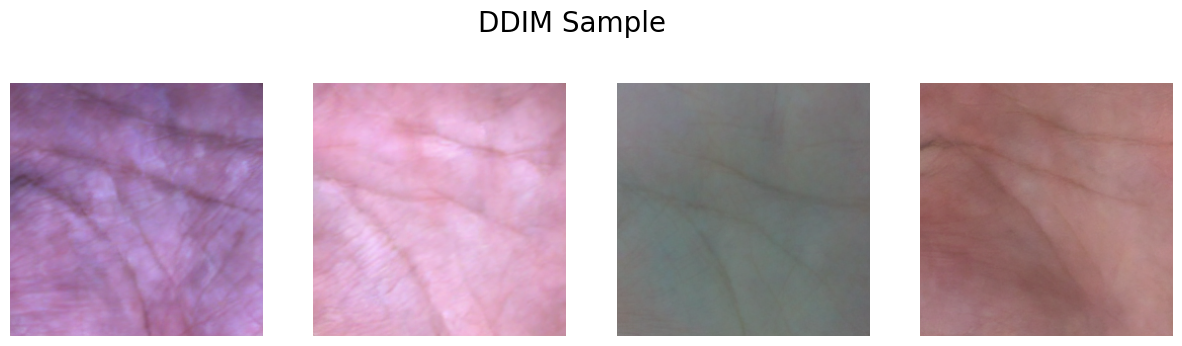

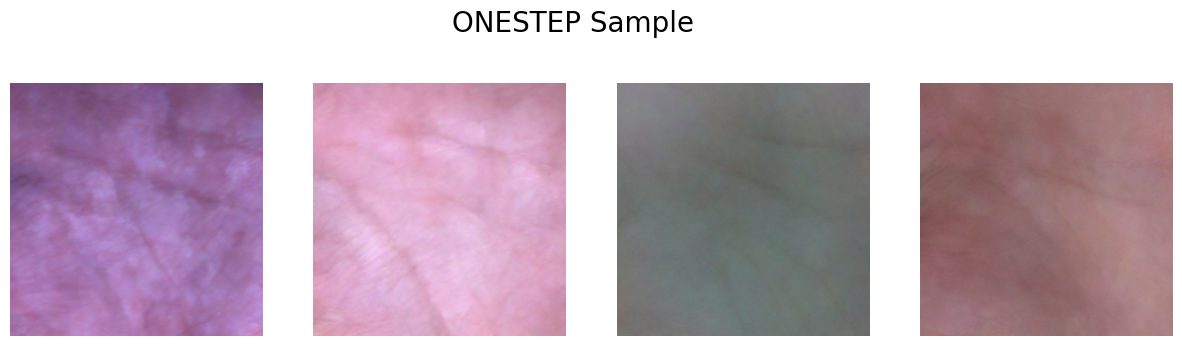

In [5]:
#Step 4 : 实验与输出

def show_images(images, title):
    # 将图片从 Tensor 转换为 numpy，并反标准化到 [0, 1] 范围
    images = images.detach().cpu().numpy()
    images = (images + 1) / 2  # 将图像从 [-1, 1] 归一化到 [0, 1]
    images = np.transpose(images, (0, 2, 3, 1))  # 转换为 (batch_size, H, W, C)

    # 仅展示前 4 张图片
    images = images[:4]

    fig, axs = plt.subplots(1, len(images), figsize=(15, 4))
    fig.suptitle(title, fontsize=20)

    # 调整标题和图片之间的间距
    plt.subplots_adjust(top=0.85, hspace=0.5)

    for i, img in enumerate(images):
        if img.shape[-1] == 1:  # 单通道图像
            axs[i].imshow(img.squeeze(), cmap='gray')
        else:  # 多通道图像
            axs[i].imshow(img)
        axs[i].axis('off')
    
    plt.show()

batchsize = 4
noise = torch.randn((batchsize, 3, 64, 64), device=device)

#ddim采样
with torch.no_grad():
    latent = gaussian_diffusion.ddim_sample(Unet, 
                                            image_size=64, 
                                            noise = noise,
                                            batch_size=batchsize, 
                                            channels=3, 
                                            ddim_timesteps=200)
    ddimImage = vq_model.decode(latent)
    
#一步采样
with torch.no_grad():
    t = torch.full((batchsize,), 999, device=device, dtype=torch.long)
    onesteplatent = onestep(noise,t)
    onestepImage = vq_model.decode(onesteplatent)

show_images(ddimImage,"DDIM Sample")
show_images(onestepImage,"ONESTEP Sample")

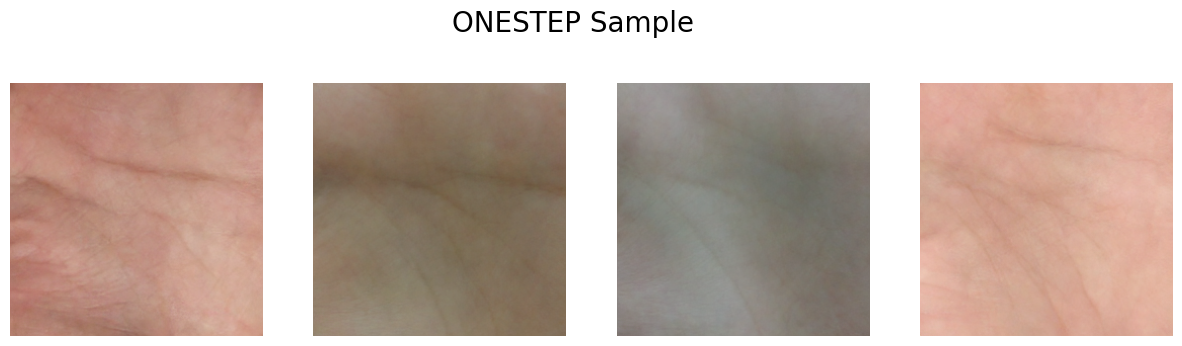

In [6]:
noise2 = torch.randn((batchsize, 3, 64, 64), device=device)
#一步采样
with torch.no_grad():
    t = torch.full((batchsize,), 999, device=device, dtype=torch.long)
    onesteplatent = onestep(noise2,t)
    onestepImage = vq_model.decode(onesteplatent)

show_images(onestepImage,"ONESTEP Sample")

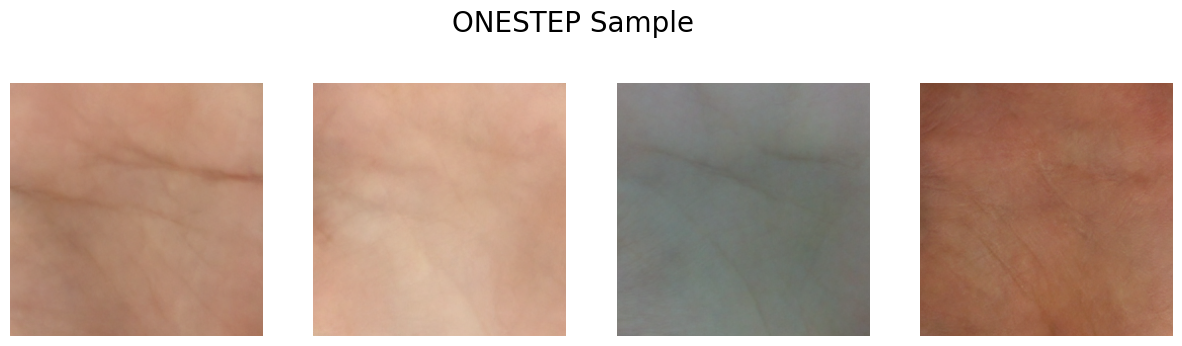

In [7]:
noise2 = torch.randn((batchsize, 3, 64, 64), device=device)
#一步采样
with torch.no_grad():
    t = torch.full((batchsize,), 999, device=device, dtype=torch.long)
    onesteplatent = onestep(noise2,t)
    onestepImage = vq_model.decode(onesteplatent)

show_images(onestepImage,"ONESTEP Sample")

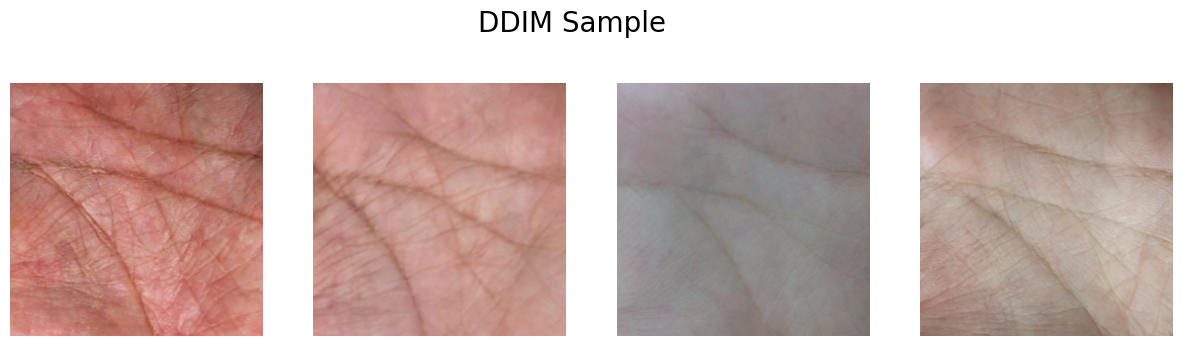

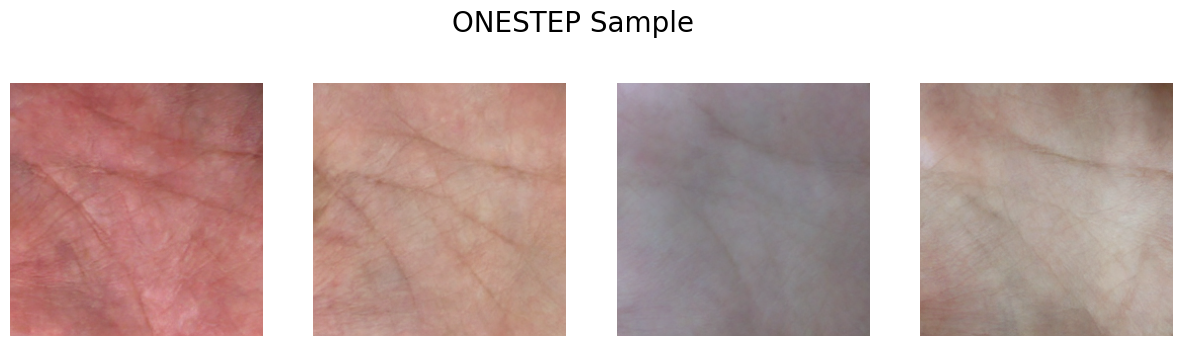

In [8]:
batchsize = 4
noise = torch.randn((batchsize, 3, 64, 64), device=device)

#ddim采样
with torch.no_grad():
    latent = gaussian_diffusion.ddim_sample(Unet, 
                                            image_size=64, 
                                            noise = noise,
                                            batch_size=batchsize, 
                                            channels=3, 
                                            ddim_timesteps=200)
    ddimImage = vq_model.decode(latent)
    
#一步采样
with torch.no_grad():
    t = torch.full((batchsize,), 999, device=device, dtype=torch.long)
    onesteplatent = onestep(noise,t)
    onestepImage = vq_model.decode(onesteplatent)

show_images(ddimImage,"DDIM Sample")
show_images(onestepImage,"ONESTEP Sample")

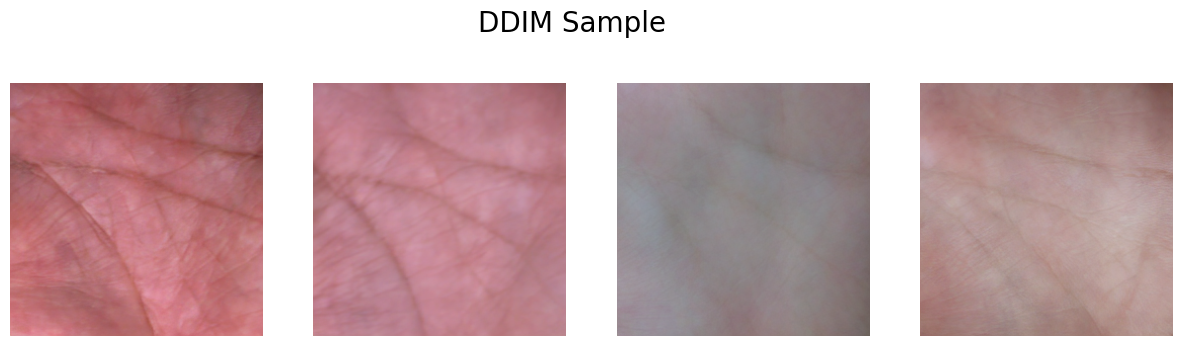

In [9]:
#ddim采样
with torch.no_grad():
    latent = gaussian_diffusion.ddim_sample(Unet, 
                                            image_size=64, 
                                            noise = noise,
                                            batch_size=batchsize, 
                                            channels=3, 
                                            ddim_timesteps=20)
    ddimImage = vq_model.decode(latent)

show_images(ddimImage,"DDIM Sample")

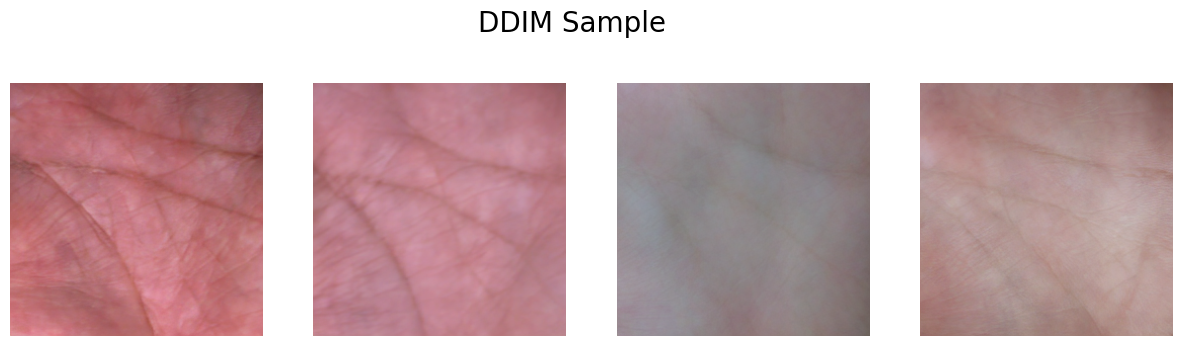

In [10]:
#ddim采样
with torch.no_grad():
    latent = gaussian_diffusion.ddim_sample(Unet, 
                                            image_size=64, 
                                            noise = noise,
                                            batch_size=batchsize, 
                                            channels=3, 
                                            ddim_timesteps=20)
    ddimImage = vq_model.decode(latent)

show_images(ddimImage,"DDIM Sample")

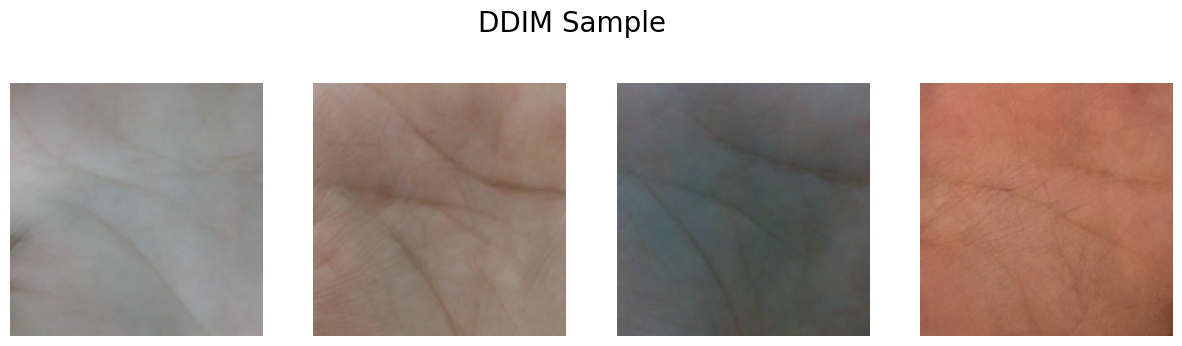

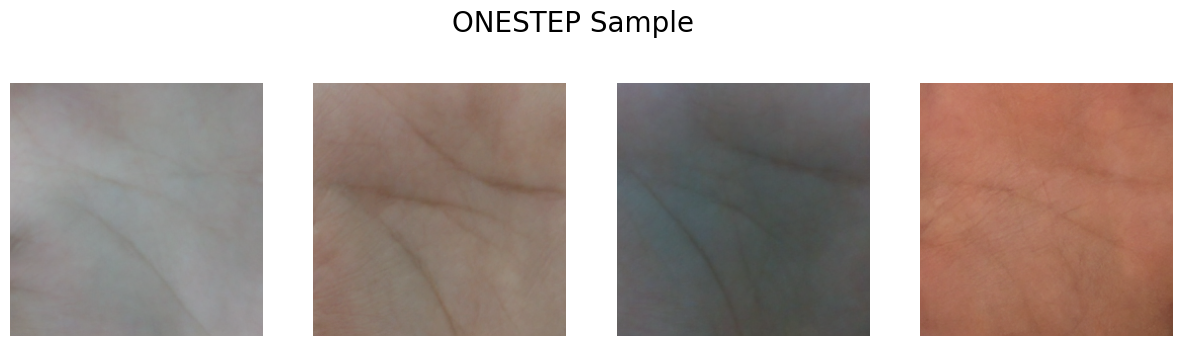

In [11]:
#step 1: 加载数据
class NoiseToImageDataset(Dataset):
    def __init__(self, noise_dir, image_dir):
        self.noise_dir = noise_dir
        self.image_dir = image_dir
        self.noise_files = sorted([f for f in os.listdir(noise_dir) if f.endswith('.pt')])
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('_generated.pt')])

        assert len(self.noise_files) == len(self.image_files), "噪声文件与生成图像文件数量不匹配！"

    def __len__(self):
        return len(self.noise_files)

    def __getitem__(self, idx):
        # 加载噪声
        noise_file = self.noise_files[idx]
        noise_path = os.path.join(self.noise_dir, noise_file)
        noise = torch.load(noise_path,weights_only=True)

        # 加载对应的生成图像
        image_file = noise_file.replace('.pt', '_generated.pt')
        image_path = os.path.join(self.image_dir, image_file)
        image = torch.load(image_path,weights_only=True)

        return noise, image

# 定义噪声和生成图像的文件夹路径
noise_dir = '/root/onethingai-fs/noise_samples'
image_dir = '/root/onethingai-fs/generated_tensors'

# 创建自定义数据集
dataset = NoiseToImageDataset(noise_dir, image_dir)

# 使用 DataLoader 加载数据集
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=16,pin_memory=True)

noise , _ = next(iter(dataloader))
noise = noise.to(device)
#ddim采样
with torch.no_grad():
    latent = gaussian_diffusion.ddim_sample(Unet, 
                                            image_size=64, 
                                            noise = noise,
                                            batch_size=batchsize, 
                                            channels=3, 
                                            ddim_timesteps=200)
    ddimImage = vq_model.decode(latent)
    
#一步采样
with torch.no_grad():
    t = torch.full((batchsize,), 999, device=device, dtype=torch.long)
    onesteplatent = onestep(noise,t)
    onestepImage = vq_model.decode(onesteplatent)

show_images(ddimImage,"DDIM Sample")
show_images(onestepImage,"ONESTEP Sample")